### EDA PROJECT: E-Commerce Analytics And Customer Segmentation

**Customer Segmentation using RFM and K-Means Clustering Technique**

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/ecommerce-data/data.csv


In [2]:
df= pd.read_csv('../ecommerce_data.csv')

#copy data into new df for analysis
data=df.copy()

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
#drop null values
data.dropna(inplace=True)

# drop negative quantity values
data = data[(data['Quantity']>0)]

#calculating total the total amount for each line item (unit price * Quantity)
data['amount']= data['Quantity']* data['UnitPrice']

#convert column to datetime
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])

#setting date of analysis= 1 day after the most recent invoice
analysis_date = pd.to_datetime(data['InvoiceDate'].max())+ dt.timedelta(days=1)

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


<AxesSubplot:ylabel='amount'>

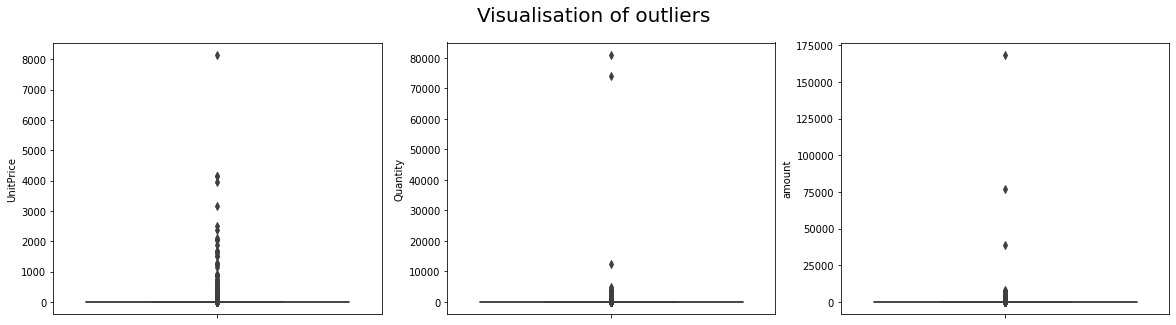

In [5]:
# See outliers
fig = plt.figure(figsize = (20,5))
fig.suptitle("Visualisation of outliers",size=20)

axes = fig.add_subplot(1, 3, 1)
sns.boxplot(data=data,y="UnitPrice")

axes = fig.add_subplot(1, 3, 2)
sns.boxplot(data=data,y="Quantity")

axes = fig.add_subplot(1, 3, 3)
sns.boxplot(data=data,y="amount")

In [6]:
# remove values that are out of the 99,7% range
data = data[(np.abs(stats.zscore(data[["amount"]])) < 3).all(axis=1)]

### K-Means Clustering:

Now, we will be approaching the segmentation using K-Means Clustering, a popular unsupervised learning algorithm. But before we start, we need to process the data to adhere to the following assumptions of K-Means Clustering with the techiques mentioned below:

1. K-Means assumes that the variables are not skewed. We will test our R,F,M values. If they are skewed, we will use logarithmic transformation to eliminate the skewness

2. K-Means assumes that all the variables have a similar mean and variance. Therefore, we will check the range and mean of each of the variables and if they are dissimilar, we will be using the Standard Scalar to normalize them

In [7]:
df_kmeans = data.groupby(['CustomerID'])\
                .agg({'InvoiceDate': lambda x: (analysis_date - x.max()).days,
                      'InvoiceNo': 'count',
                      'amount': 'sum'})\

#rename each column to denote the R,F,M Values
df_kmeans.rename(columns = {'InvoiceDate': 'Recency',
                                   'InvoiceNo': 'Frequency',
                                   'amount': 'Monetary'}, inplace=True)

<AxesSubplot:xlabel='Recency', ylabel='Density'>

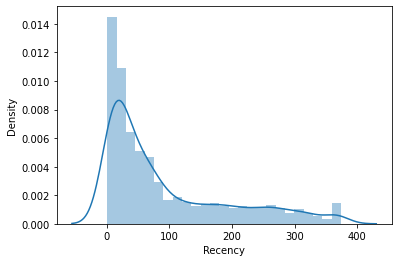

In [8]:
#plot the skewness of recency metric
sns.distplot(df_kmeans['Recency'])

<AxesSubplot:xlabel='Frequency', ylabel='Density'>

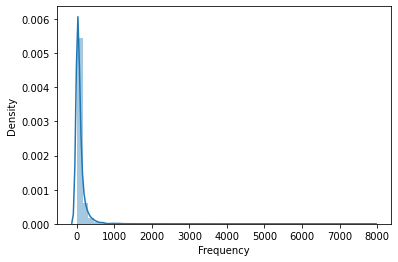

In [9]:
#plot the skewness of frequency metric
sns.distplot(df_kmeans['Frequency'])

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

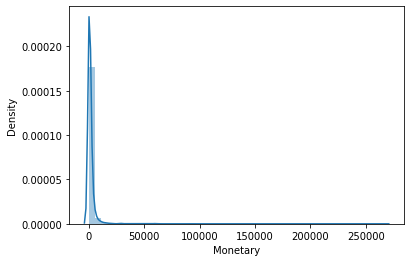

In [10]:
#plot the skewness of monetary metric
sns.distplot(df_kmeans['Monetary'])

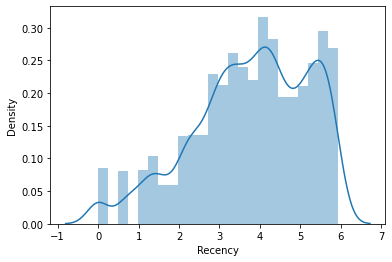

In [11]:
#log transformation of recency metric
recency_log= np.log(df_kmeans['Recency'])

#plot the transformed variable
sns.distplot(recency_log)
plt.show()

In [12]:
#check for variance and mean of the variables
df_kmeans.describe()

,Recency,Frequency,Monetary
count,4334.000000,4334.000000,4334.000000
mean,92.569912,91.735118,1847.235156
std,99.949300,228.800180,6827.612799
min,1.000000,1.000000,0.000000
25%,18.000000,17.000000,306.592500
50%,51.000000,41.000000,668.250000
75%,142.000000,100.000000,1633.277500
max,374.000000,7847.000000,266889.860000


In [13]:
rfm = df_kmeans[['Recency','Frequency','Monetary']]

#making all values in Monetary positive
rfm['Monetary']=rfm['Monetary']+1

#applying logarithmic transformation
for c in ['Recency', 'Frequency']:
    rfm[c]= np.log(rfm[c])
    

#Normalization of variables
from sklearn.preprocessing import StandardScaler

ecomm_standardized= StandardScaler().fit_transform(rfm)
rfm[['Recency','Frequency','Monetary']]=ecomm_standardized.round(2)

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,-2.15,1.15,0.36
12348.0,0.38,-0.19,-0.01
12349.0,-0.58,0.46,-0.01
12350.0,1.37,-0.64,-0.22
12352.0,-0.13,0.57,0.10


The above step concludes the pre-processig of the data. Now, we use the elbow criterion method to find the optinum number of clusters.

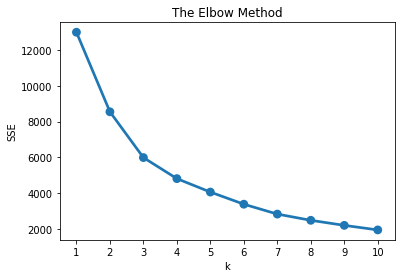

In [14]:
#start k-means clustering
from sklearn.cluster import KMeans

sse = {}

#find the optimum number of clusters from 1 to 10
for k in range(1, 11):    
    elbow_model = KMeans(n_clusters=k, random_state=1)    
    elbow_model.fit(rfm)    
    sse[k] = elbow_model.inertia_ 
    
# Plot SSE for each value of k    
plt.title('The Elbow Method')
plt.xlabel('k'); 
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [19]:
#fit k-means with 4 clusters
model = KMeans(n_clusters=4,n_init = 30,random_state=3)    
model.fit(rfm)

#adding column with cluster labels to a new df
cluster_table = df_kmeans.assign(Cluster=model.labels_)

#group by cluster
clustered_data = cluster_table.groupby(['Cluster'])

#average RFM values for each cluster
clustered_data.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
  }).round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,68.96,74.60,1224.13
1,8.84,218.68,3849.98
2,179.70,13.88,371.74
3,7.88,1527.19,88707.14


In [20]:
labels = model.labels_
print("Silhouette score:", metrics.silhouette_score(rfm,labels))
print("Calinski Harabasz Scorescore:", metrics.calinski_harabasz_score(rfm, labels))
print("Davies Bouldin Score:", metrics.davies_bouldin_score(rfm,labels))

Silhouette score: 0.32702257971078924
Calinski Harabasz Scorescore: 2461.3225274019933
Davies Bouldin Score: 0.9216679809972602


In [23]:
# Classify the customer based on the clusters
labels = model.labels_
df_kmeans['Group']= labels
df_kmeans.head()

,Recency,Frequency,Monetary,Group
CustomerID,,,,
12347.0,2,182,4310.00,1
12348.0,75,31,1797.24,0
12349.0,19,73,1757.55,0
12350.0,310,17,334.40,2
12352.0,36,85,2506.04,0


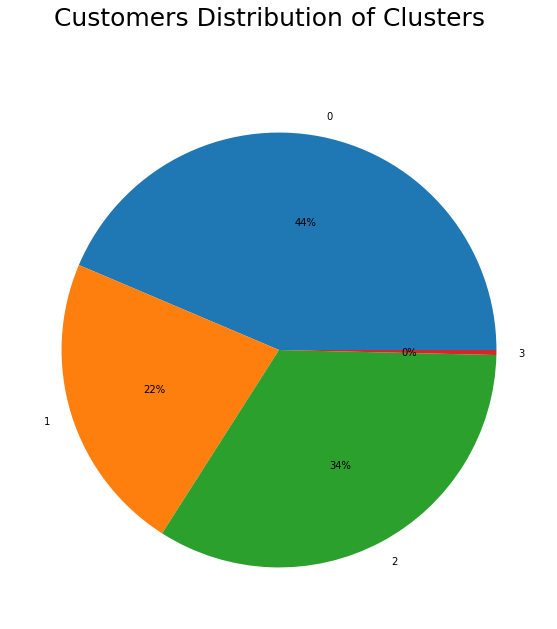

In [22]:
clusters_count = df_kmeans.groupby('Group').agg({"Recency": "count"})
clusters_count.reset_index(inplace=True)
clusters_count.columns = ['cluster', 'count']

fig  = plt.figure(figsize = (10,10)).suptitle('Customers Distribution of Clusters', fontsize=25)
plt.pie(clusters_count["count"], labels = clusters_count["cluster"], autopct='%.0f%%')

plt.show()